In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import *
import numpy as np
%matplotlib inline

## Подготовка и визуализация данных

In [2]:
train_loader, valid_loader, test_loader = mnist(valid=10000, batch_size=50)

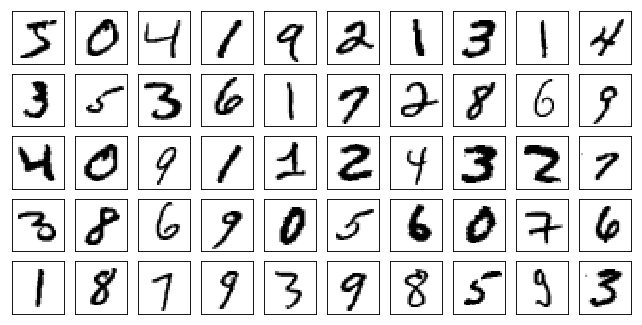

In [3]:
images = mnist_plotdata()
plot_mnist(images, (5, 10))

## Обучение классификатора

In [4]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU()):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [5]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh):
        super(FullyConnected, self).__init__()
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))            
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [6]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        
        
        self._conv1 = ConvLayer([1, 16, 3], bn=batchnorm)
        self._conv2 = ConvLayer([16, 32, 3], bn=batchnorm, activation_fn=nn.Sigmoid())
        
        self.fc = FullyConnected([32*7*7, 10], dropout=dropout)
        
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
    
    def conv(self, x):
        x = self._conv1(x)
        x = self._conv2(x)
        return x
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 32*7*7)
        x = self.fc(x)
        
        return x
    
    def loss(self, output, target, **kwargs):           
        self._loss = F.cross_entropy(output, target, **kwargs)
        self._correct = output.data.max(1, keepdim=True)[1]
        self._correct = self._correct.eq(target.data.view_as(self._correct)).to(torch.float).cpu().mean()
        return self._loss

In [7]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._correct))
        print(line + losses)

In [8]:
models = {'bn': Net(True), 'drop': Net(False, True), 'plain': Net()}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [9]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], target, size_average=False).item() # sum up batch loss
                pred = output[k].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: c / test_size for k, c in correct.items()}
    lines = '\n'.join([line(k, test_loss[k], correct[k], 100*correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [10]:
for epoch in range(1, 41):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses bn: 2.327237 drop: 2.327067 plain: 2.398716
Train Epoch: 1 [10000/50000 (20%)]	Losses bn: 1.940708 drop: 2.064648 plain: 2.166881
Train Epoch: 1 [20000/50000 (40%)]	Losses bn: 1.701396 drop: 1.560394 plain: 1.792192
Train Epoch: 1 [30000/50000 (60%)]	Losses bn: 1.356526 drop: 1.018548 plain: 1.202888
Train Epoch: 1 [40000/50000 (80%)]	Losses bn: 0.990829 drop: 0.651022 plain: 0.738635
Train Epoch: 1 [50000/50000 (100%)]	Losses bn: 0.963648 drop: 0.721057 plain: 0.716659
Test set:
bn: Loss: 0.9073	Accuracy: 8850.0/10000 (88%)
drop: Loss: 0.6407	Accuracy: 8445.0/10000 (84%)
plain: Loss: 0.6657	Accuracy: 8510.0/10000 (85%)

Train Epoch: 2 [0/50000 (0%)]	Losses bn: 0.997129 drop: 0.727063 plain: 0.745833
Train Epoch: 2 [10000/50000 (20%)]	Losses bn: 0.682070 drop: 0.406315 plain: 0.428687
Train Epoch: 2 [20000/50000 (40%)]	Losses bn: 0.486867 drop: 0.359889 plain: 0.347797
Train Epoch: 2 [30000/50000 (60%)]	Losses bn: 0.545352 drop: 0.371274 plain: 0.34

Train Epoch: 13 [30000/50000 (60%)]	Losses bn: 0.097599 drop: 0.141717 plain: 0.099757
Train Epoch: 13 [40000/50000 (80%)]	Losses bn: 0.087630 drop: 0.099346 plain: 0.125132
Train Epoch: 13 [50000/50000 (100%)]	Losses bn: 0.072654 drop: 0.091802 plain: 0.093036
Test set:
bn: Loss: 0.0702	Accuracy: 9790.0/10000 (98%)
drop: Loss: 0.0874	Accuracy: 9761.0/10000 (98%)
plain: Loss: 0.0818	Accuracy: 9784.0/10000 (98%)

Train Epoch: 14 [0/50000 (0%)]	Losses bn: 0.029795 drop: 0.061071 plain: 0.057620
Train Epoch: 14 [10000/50000 (20%)]	Losses bn: 0.078697 drop: 0.104760 plain: 0.097463
Train Epoch: 14 [20000/50000 (40%)]	Losses bn: 0.039354 drop: 0.049134 plain: 0.053806
Train Epoch: 14 [30000/50000 (60%)]	Losses bn: 0.115576 drop: 0.137587 plain: 0.077492
Train Epoch: 14 [40000/50000 (80%)]	Losses bn: 0.049868 drop: 0.040388 plain: 0.031665
Train Epoch: 14 [50000/50000 (100%)]	Losses bn: 0.050742 drop: 0.038363 plain: 0.041651
Test set:
bn: Loss: 0.0659	Accuracy: 9822.0/10000 (98%)
drop: Loss

Train Epoch: 25 [50000/50000 (100%)]	Losses bn: 0.062874 drop: 0.063268 plain: 0.067614
Test set:
bn: Loss: 0.0466	Accuracy: 9864.0/10000 (99%)
drop: Loss: 0.0584	Accuracy: 9846.0/10000 (98%)
plain: Loss: 0.0562	Accuracy: 9838.0/10000 (98%)

Train Epoch: 26 [0/50000 (0%)]	Losses bn: 0.026951 drop: 0.027114 plain: 0.026477
Train Epoch: 26 [10000/50000 (20%)]	Losses bn: 0.022352 drop: 0.034438 plain: 0.032168
Train Epoch: 26 [20000/50000 (40%)]	Losses bn: 0.020409 drop: 0.032141 plain: 0.032243
Train Epoch: 26 [30000/50000 (60%)]	Losses bn: 0.005217 drop: 0.033979 plain: 0.023460
Train Epoch: 26 [40000/50000 (80%)]	Losses bn: 0.025118 drop: 0.013730 plain: 0.014087
Train Epoch: 26 [50000/50000 (100%)]	Losses bn: 0.044910 drop: 0.037579 plain: 0.045741
Test set:
bn: Loss: 0.0484	Accuracy: 9867.0/10000 (99%)
drop: Loss: 0.0591	Accuracy: 9844.0/10000 (98%)
plain: Loss: 0.0568	Accuracy: 9841.0/10000 (98%)

Train Epoch: 27 [0/50000 (0%)]	Losses bn: 0.018049 drop: 0.011464 plain: 0.011011
Trai

Train Epoch: 38 [10000/50000 (20%)]	Losses bn: 0.005484 drop: 0.023479 plain: 0.014725
Train Epoch: 38 [20000/50000 (40%)]	Losses bn: 0.021665 drop: 0.028262 plain: 0.029909
Train Epoch: 38 [30000/50000 (60%)]	Losses bn: 0.003145 drop: 0.008260 plain: 0.005832
Train Epoch: 38 [40000/50000 (80%)]	Losses bn: 0.017277 drop: 0.018855 plain: 0.023037
Train Epoch: 38 [50000/50000 (100%)]	Losses bn: 0.071951 drop: 0.054389 plain: 0.047094
Test set:
bn: Loss: 0.0425	Accuracy: 9877.0/10000 (99%)
drop: Loss: 0.0506	Accuracy: 9862.0/10000 (99%)
plain: Loss: 0.0484	Accuracy: 9858.0/10000 (99%)

Train Epoch: 39 [0/50000 (0%)]	Losses bn: 0.003092 drop: 0.005656 plain: 0.006828
Train Epoch: 39 [10000/50000 (20%)]	Losses bn: 0.009749 drop: 0.012060 plain: 0.008190
Train Epoch: 39 [20000/50000 (40%)]	Losses bn: 0.024282 drop: 0.028808 plain: 0.028665
Train Epoch: 39 [30000/50000 (60%)]	Losses bn: 0.031108 drop: 0.047713 plain: 0.055226
Train Epoch: 39 [40000/50000 (80%)]	Losses bn: 0.002226 drop: 0.009

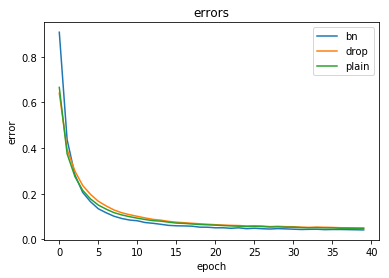

In [11]:
plot_graphs(test_log, 'loss')

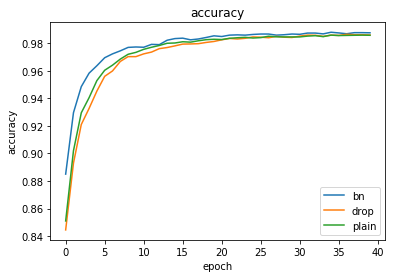

In [12]:
plot_graphs(test_log, 'accuracy')

In [13]:
torch.save(models['bn'], './model_classifier_convs')

/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type ConvLayer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type FullyConnected. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Оптимизация изображений

In [10]:
model = torch.load('./model_classifier_convs')

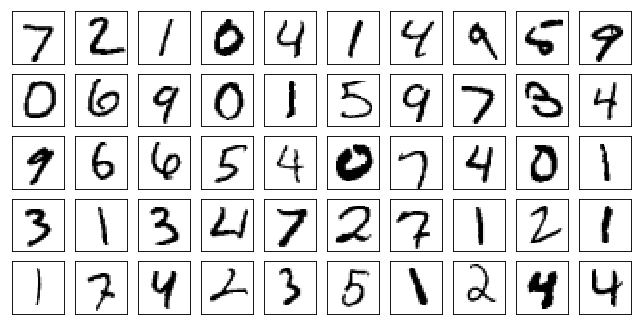

[tensor(7), tensor(2), tensor(1), tensor(0), tensor(4), tensor(1), tensor(4), tensor(9), tensor(5), tensor(9), tensor(0), tensor(6), tensor(9), tensor(0), tensor(1), tensor(5), tensor(9), tensor(7), tensor(3), tensor(4), tensor(9), tensor(6), tensor(6), tensor(5), tensor(4), tensor(0), tensor(7), tensor(4), tensor(0), tensor(1), tensor(3), tensor(1), tensor(3), tensor(4), tensor(7), tensor(2), tensor(7), tensor(1), tensor(2), tensor(1), tensor(1), tensor(7), tensor(4), tensor(2), tensor(3), tensor(5), tensor(1), tensor(2), tensor(4), tensor(4)]


In [11]:
data, _ = next(iter(test_loader))
output = model.forward(data)
predictions = [output[i].argmax() for i in range(50)]
plot_mnist(data.data.numpy(), (5, 10))

print (predictions)

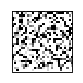

In [12]:
data, _ = next(iter(test_loader))
#img = data[2].view(-1, 1, 28, 28)
img = torch.randn((1, 784)).view(-1, 1, 28, 28)
to_plot = img.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
plot_mnist(to_plot, (1, 1))


In [13]:
from torch.autograd import Variable

def generate_image(img, cl):
    
    gen_img_par = Variable(img, requires_grad=True)    
    target = torch.ones((1), dtype=torch.long) * cl
    #target[cl] = 1
    #target = target.view(1, 10)
    
    loss_stats = []    
    gen_optim = optim.RMSprop([gen_img_par], lr=1e-4, weight_decay=0.)
        
    for i in range(1, 10000001):  
             
        out = model.forward(gen_img_par)        
             
        gen_optim.zero_grad()
        loss = F.cross_entropy(out, target)    
        loss.backward()          
        gen_optim.step()
        
        if i % 10000 == 0:    
            print ("Iteration {}: loss={} prediction={}".format(i,loss, out.argmax()))
            ls = loss.detach().numpy()            
            loss_stats.append(ls)
            
            #1print("PRED=", out.argmax())
            #print("OUT=", out)
            #print("TR=", target)
                        
            if len(loss_stats) > 1000:    
                if ls > loss_stats[-2] and ls > loss_stats[-3] and ls > loss_stats[-4] and ls > loss_stats[-5]:
                    print ("Loss is rising .. stop")
                    break

        if i % 100000 == 0:
            to_plot = gen_img_par.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
            plot_mnist(to_plot, (1, 1))
       
   
                        
    return gen_img_par, loss_stats    

Iteration 10000: loss=4.193962155341069e-08 prediction=4
Iteration 20000: loss=1.9337599965751906e-08 prediction=4
Iteration 30000: loss=1.6678434633377037e-08 prediction=4
Iteration 40000: loss=1.386622727750364e-08 prediction=4
Iteration 50000: loss=1.212473144107662e-08 prediction=4
Iteration 60000: loss=1.0852314602516344e-08 prediction=4
Iteration 70000: loss=9.80789671700677e-09 prediction=4
Iteration 80000: loss=8.94078944213561e-09 prediction=4
Iteration 90000: loss=8.212403201923735e-09 prediction=4
Iteration 100000: loss=7.48259054716982e-09 prediction=4


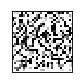

Iteration 110000: loss=6.7842620410374366e-09 prediction=4
Iteration 120000: loss=6.348386705212761e-09 prediction=4
Iteration 130000: loss=6.044819755857134e-09 prediction=4
Iteration 140000: loss=5.786390033790667e-09 prediction=4
Iteration 150000: loss=5.5470490423203955e-09 prediction=4
Iteration 160000: loss=5.325576424297651e-09 prediction=4
Iteration 170000: loss=5.1254769317665705e-09 prediction=4
Iteration 180000: loss=4.942441123034769e-09 prediction=4
Iteration 190000: loss=4.771145256654563e-09 prediction=4
Iteration 200000: loss=4.614564730331949e-09 prediction=4


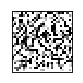

Iteration 210000: loss=4.448667212386681e-09 prediction=4
Iteration 220000: loss=4.290452437771819e-09 prediction=4
Iteration 230000: loss=4.1429188968322705e-09 prediction=4
Iteration 240000: loss=4.020943578098013e-09 prediction=4
Iteration 250000: loss=3.914450985575968e-09 prediction=4
Iteration 260000: loss=3.810821880279036e-09 prediction=4
Iteration 270000: loss=3.6956357973849663e-09 prediction=4
Iteration 280000: loss=3.566361428397613e-09 prediction=4
Iteration 290000: loss=3.4456917319403146e-09 prediction=4
Iteration 300000: loss=3.3387017595032376e-09 prediction=4


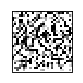

Iteration 310000: loss=3.2371119118579372e-09 prediction=4
Iteration 320000: loss=3.1377247466934932e-09 prediction=4
Iteration 330000: loss=3.0444677889818195e-09 prediction=4
Iteration 340000: loss=2.953013833462137e-09 prediction=4
Iteration 350000: loss=2.87161405765346e-09 prediction=4
Iteration 360000: loss=2.803311360821681e-09 prediction=4
Iteration 370000: loss=2.7388029621988608e-09 prediction=4
Iteration 380000: loss=2.6832491784034573e-09 prediction=4
Iteration 390000: loss=2.6268782704619298e-09 prediction=4
Iteration 400000: loss=2.571429291720051e-09 prediction=4


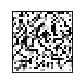

Iteration 410000: loss=2.517035468940776e-09 prediction=4
Iteration 420000: loss=2.4661552799898345e-09 prediction=4
Iteration 430000: loss=2.421128186824717e-09 prediction=4
Iteration 440000: loss=2.3820749817105025e-09 prediction=4
Iteration 450000: loss=2.3466757426149343e-09 prediction=4
Iteration 460000: loss=2.3144526295482137e-09 prediction=4
Iteration 470000: loss=2.283272237946221e-09 prediction=4
Iteration 480000: loss=2.2546302602677315e-09 prediction=4
Iteration 490000: loss=2.227466211479623e-09 prediction=4
Iteration 500000: loss=2.2001618305012016e-09 prediction=4


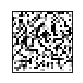

Iteration 510000: loss=2.173676350025744e-09 prediction=4
Iteration 520000: loss=2.148095035181541e-09 prediction=4
Iteration 530000: loss=2.1247679171665368e-09 prediction=4
Iteration 540000: loss=2.1038530917394382e-09 prediction=4
Iteration 550000: loss=2.083535122210378e-09 prediction=4
Iteration 560000: loss=2.0659136623635277e-09 prediction=4
Iteration 570000: loss=2.049068470455495e-09 prediction=4
Iteration 580000: loss=2.030743573300242e-09 prediction=4
Iteration 590000: loss=2.0123014365935887e-09 prediction=4
Iteration 600000: loss=1.9953461105615133e-09 prediction=4


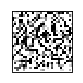

Iteration 610000: loss=1.978936126079134e-09 prediction=4
Iteration 620000: loss=1.9624959435304845e-09 prediction=4
Iteration 630000: loss=1.945416272519651e-09 prediction=4
Iteration 640000: loss=1.928667003880946e-09 prediction=4
Iteration 650000: loss=1.9119692495905838e-09 prediction=4
Iteration 660000: loss=1.895012147201669e-09 prediction=4
Iteration 670000: loss=1.877632271884977e-09 prediction=4
Iteration 680000: loss=1.8558363734655359e-09 prediction=4
Iteration 690000: loss=1.829443263545727e-09 prediction=4
Iteration 700000: loss=1.8022277004092757e-09 prediction=4


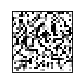

Iteration 710000: loss=1.7790409145845842e-09 prediction=4
Iteration 720000: loss=1.7564847354378799e-09 prediction=4
Iteration 730000: loss=1.7349126579802032e-09 prediction=4
Iteration 740000: loss=1.7134951235675544e-09 prediction=4
Iteration 750000: loss=1.6918448864089441e-09 prediction=4
Iteration 760000: loss=1.6724115425859054e-09 prediction=4
Iteration 770000: loss=1.653148729019449e-09 prediction=4
Iteration 780000: loss=1.6352750265014038e-09 prediction=4
Iteration 790000: loss=1.6182681861209858e-09 prediction=4
Iteration 800000: loss=1.602158405944465e-09 prediction=4


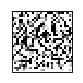

Iteration 810000: loss=1.5863257374348905e-09 prediction=4
Iteration 820000: loss=1.5709709089151147e-09 prediction=4
Iteration 830000: loss=1.55608681495778e-09 prediction=4
Iteration 840000: loss=1.5416059540029892e-09 prediction=4
Iteration 850000: loss=1.527203252749132e-09 prediction=4
Iteration 860000: loss=1.5130847685895787e-09 prediction=4
Iteration 870000: loss=1.4991350383297686e-09 prediction=4
Iteration 880000: loss=1.4855405794378385e-09 prediction=4
Iteration 890000: loss=1.4724186314651888e-09 prediction=4
Iteration 900000: loss=1.4582557383846506e-09 prediction=4


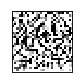

Iteration 910000: loss=1.444179886789243e-09 prediction=4
Iteration 920000: loss=1.4303527251513515e-09 prediction=4
Iteration 930000: loss=1.416596617787036e-09 prediction=4
Iteration 940000: loss=1.403087424023397e-09 prediction=4
Iteration 950000: loss=1.389643955462816e-09 prediction=4
Iteration 960000: loss=1.3765006912080935e-09 prediction=4
Iteration 970000: loss=1.3640022444860733e-09 prediction=4
Iteration 980000: loss=1.3519745323264942e-09 prediction=4
Iteration 990000: loss=1.3401031395687824e-09 prediction=4
Iteration 1000000: loss=1.3285141875485351e-09 prediction=4


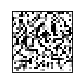

Iteration 1010000: loss=1.3172680723982921e-09 prediction=4
Iteration 1020000: loss=1.3064003212548414e-09 prediction=4
Iteration 1030000: loss=1.2956657968743457e-09 prediction=4
Iteration 1040000: loss=1.2850236430494988e-09 prediction=4
Iteration 1050000: loss=1.2746070865432557e-09 prediction=4
Iteration 1060000: loss=1.2644747471313167e-09 prediction=4
Iteration 1070000: loss=1.2546301775273605e-09 prediction=4
Iteration 1080000: loss=1.2450378505945991e-09 prediction=4
Iteration 1090000: loss=1.2359375745063517e-09 prediction=4
Iteration 1100000: loss=1.2272156624248964e-09 prediction=4


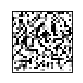

Iteration 1110000: loss=1.2192451492865075e-09 prediction=4
Iteration 1120000: loss=1.211400757483716e-09 prediction=4
Iteration 1130000: loss=1.2036593943776097e-09 prediction=4
Iteration 1140000: loss=1.1959766510472036e-09 prediction=4
Iteration 1150000: loss=1.1883880546292858e-09 prediction=4
Iteration 1160000: loss=1.18103038460049e-09 prediction=4
Iteration 1170000: loss=1.1739391680976041e-09 prediction=4
Iteration 1180000: loss=1.1669811783576733e-09 prediction=4
Iteration 1190000: loss=1.160255891363704e-09 prediction=4
Iteration 1200000: loss=1.153745543547302e-09 prediction=4


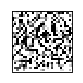

Iteration 1210000: loss=1.1477840899942748e-09 prediction=4
Iteration 1220000: loss=1.1419096779263782e-09 prediction=4
Iteration 1230000: loss=1.1360707929952696e-09 prediction=4
Iteration 1240000: loss=1.1303864511091888e-09 prediction=4
Iteration 1250000: loss=1.1247678344261658e-09 prediction=4
Iteration 1260000: loss=1.1191954030209672e-09 prediction=4
Iteration 1270000: loss=1.1138183708681026e-09 prediction=4
Iteration 1280000: loss=1.1082796902428527e-09 prediction=4
Iteration 1290000: loss=1.1023839618928832e-09 prediction=4
Iteration 1300000: loss=1.0966729746542114e-09 prediction=4


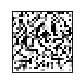

Iteration 1310000: loss=1.0911307413152826e-09 prediction=4
Iteration 1320000: loss=1.0856666676772875e-09 prediction=4
Iteration 1330000: loss=1.080316280877014e-09 prediction=4
Iteration 1340000: loss=1.07511510805125e-09 prediction=4
Iteration 1350000: loss=1.0697309704710278e-09 prediction=4
Iteration 1360000: loss=1.0644445325169727e-09 prediction=4
Iteration 1370000: loss=1.0593215193921424e-09 prediction=4
Iteration 1380000: loss=1.0543192985323913e-09 prediction=4
Iteration 1390000: loss=1.0495035951407772e-09 prediction=4
Iteration 1400000: loss=1.0447518405953815e-09 prediction=4


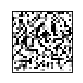

Iteration 1410000: loss=1.0401173256013863e-09 prediction=4
Iteration 1420000: loss=1.0357776858427314e-09 prediction=4
Iteration 1430000: loss=1.0316636434026805e-09 prediction=4
Iteration 1440000: loss=1.0276988149371391e-09 prediction=4
Iteration 1450000: loss=1.0238263570272466e-09 prediction=4
Iteration 1460000: loss=1.0200125188930542e-09 prediction=4
Iteration 1470000: loss=1.016283945887153e-09 prediction=4
Iteration 1480000: loss=1.0125589255949308e-09 prediction=4
Iteration 1490000: loss=1.00885877429846e-09 prediction=4
Iteration 1500000: loss=1.005219019134529e-09 prediction=4


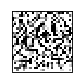

Iteration 1510000: loss=1.0015632767590432e-09 prediction=4
Iteration 1520000: loss=9.97891547172003e-10 prediction=4
Iteration 1530000: loss=9.942606737922688e-10 prediction=4
Iteration 1540000: loss=9.90667103906162e-10 prediction=4
Iteration 1550000: loss=9.872014317124922e-10 prediction=4
Iteration 1560000: loss=9.837535230872163e-10 prediction=4
Iteration 1570000: loss=9.80348247026086e-10 prediction=4
Iteration 1580000: loss=9.770388942342834e-10 prediction=4
Iteration 1590000: loss=9.74178959722849e-10 prediction=4
Iteration 1600000: loss=9.71320801568254e-10 prediction=4


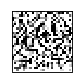

Iteration 1610000: loss=9.685887647492564e-10 prediction=4
Iteration 1620000: loss=9.658069899387556e-10 prediction=4
Iteration 1630000: loss=9.630145569872184e-10 prediction=4
Iteration 1640000: loss=9.602274531061994e-10 prediction=4
Iteration 1650000: loss=9.574101511589106e-10 prediction=4
Iteration 1660000: loss=9.545395585064398e-10 prediction=4
Iteration 1670000: loss=9.516991639202388e-10 prediction=4
Iteration 1680000: loss=9.488658747613954e-10 prediction=4
Iteration 1690000: loss=9.461249561582008e-10 prediction=4
Iteration 1700000: loss=9.434124592644366e-10 prediction=4


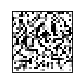

Iteration 1710000: loss=9.407088441548694e-10 prediction=4
Iteration 1720000: loss=9.380727306051995e-10 prediction=4
Iteration 1730000: loss=9.353939844913839e-10 prediction=4
Iteration 1740000: loss=9.32594446112489e-10 prediction=4
Iteration 1750000: loss=9.298979364302795e-10 prediction=4
Iteration 1760000: loss=9.273808387888494e-10 prediction=4
Iteration 1770000: loss=9.249241372799588e-10 prediction=4
Iteration 1780000: loss=9.225260555467685e-10 prediction=4
Iteration 1790000: loss=9.201226447430599e-10 prediction=4
Iteration 1800000: loss=9.1801943824521e-10 prediction=4


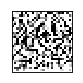

Iteration 1810000: loss=9.159606406683451e-10 prediction=4
Iteration 1820000: loss=9.139462520124653e-10 prediction=4
Iteration 1830000: loss=9.11903441647155e-10 prediction=4
Iteration 1840000: loss=9.098073405766627e-10 prediction=4
Iteration 1850000: loss=9.07665054228346e-10 prediction=4
Iteration 1860000: loss=9.055600713736567e-10 prediction=4
Iteration 1870000: loss=9.034408776642522e-10 prediction=4
Iteration 1880000: loss=9.011849044782139e-10 prediction=4
Iteration 1890000: loss=8.989093913669421e-10 prediction=4
Iteration 1900000: loss=8.966711817492978e-10 prediction=4


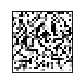

Iteration 1910000: loss=8.944240903474565e-10 prediction=4
Iteration 1920000: loss=8.92189433443491e-10 prediction=4
Iteration 1930000: loss=8.899849746057953e-10 prediction=4
Iteration 1940000: loss=8.877751866975814e-10 prediction=4
Iteration 1950000: loss=8.856488875608193e-10 prediction=4
Iteration 1960000: loss=8.83650486116494e-10 prediction=4
Iteration 1970000: loss=8.817178098752265e-10 prediction=4
Iteration 1980000: loss=8.799005968285201e-10 prediction=4
Iteration 1990000: loss=8.780975946365288e-10 prediction=4
Iteration 2000000: loss=8.76296368801377e-10 prediction=4


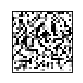

Iteration 2010000: loss=8.744791557546705e-10 prediction=4
Iteration 2020000: loss=8.727170097699855e-10 prediction=4
Iteration 2030000: loss=8.709406529305852e-10 prediction=4
Iteration 2040000: loss=8.69173177875382e-10 prediction=4
Iteration 2050000: loss=8.674057028201787e-10 prediction=4
Iteration 2060000: loss=8.655760552755964e-10 prediction=4
Iteration 2070000: loss=8.637481840878536e-10 prediction=4
Iteration 2080000: loss=8.619238656137895e-10 prediction=4
Iteration 2090000: loss=8.600800072144921e-10 prediction=4
Iteration 2100000: loss=8.582343724583552e-10 prediction=4


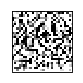

Iteration 2110000: loss=8.564651210463126e-10 prediction=4
Iteration 2120000: loss=8.546976459911093e-10 prediction=4
Iteration 2130000: loss=8.530207651347155e-10 prediction=4
Iteration 2140000: loss=8.51301251714176e-10 prediction=4
Iteration 2150000: loss=8.495710801526002e-10 prediction=4
Iteration 2160000: loss=8.477538671058937e-10 prediction=4
Iteration 2170000: loss=8.459331013455085e-10 prediction=4
Iteration 2180000: loss=8.44107006514605e-10 prediction=4
Iteration 2190000: loss=8.421778829870163e-10 prediction=4
Iteration 2200000: loss=8.403837625792221e-10 prediction=4


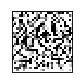

Iteration 2210000: loss=8.385878658145884e-10 prediction=4
Iteration 2220000: loss=8.368079562615094e-10 prediction=4
Iteration 2230000: loss=8.350422575631455e-10 prediction=4
Iteration 2240000: loss=8.333671530635911e-10 prediction=4
Iteration 2250000: loss=8.316813904230003e-10 prediction=4
Iteration 2260000: loss=8.30002733209767e-10 prediction=4
Iteration 2270000: loss=8.284128938385038e-10 prediction=4
Iteration 2280000: loss=8.26833712608277e-10 prediction=4
Iteration 2290000: loss=8.252776240169624e-10 prediction=4
Iteration 2300000: loss=8.237286408530053e-10 prediction=4


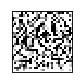

Iteration 2310000: loss=8.221814340458877e-10 prediction=4
Iteration 2320000: loss=8.206040291725003e-10 prediction=4
Iteration 2330000: loss=8.190212952285947e-10 prediction=4
Iteration 2340000: loss=8.174474430688861e-10 prediction=4
Iteration 2350000: loss=8.15907341689126e-10 prediction=4
Iteration 2360000: loss=8.143636875956872e-10 prediction=4
Iteration 2370000: loss=8.128520079253576e-10 prediction=4
Iteration 2380000: loss=8.113634208939402e-10 prediction=4
Iteration 2390000: loss=8.099192427835078e-10 prediction=4
Iteration 2400000: loss=8.085105918098634e-10 prediction=4


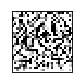

Iteration 2410000: loss=8.07110822620416e-10 prediction=4
Iteration 2420000: loss=8.057252642856838e-10 prediction=4
Iteration 2430000: loss=8.043787858014184e-10 prediction=4
Iteration 2440000: loss=8.030660580971016e-10 prediction=4
Iteration 2450000: loss=8.017746466748576e-10 prediction=4
Iteration 2460000: loss=8.004690243978985e-10 prediction=4
Iteration 2470000: loss=7.991687311914575e-10 prediction=4
Iteration 2480000: loss=7.978897542670893e-10 prediction=4
Iteration 2490000: loss=7.966320936247939e-10 prediction=4
Iteration 2500000: loss=7.954010783350896e-10 prediction=4


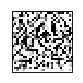

Iteration 2510000: loss=7.941931556842974e-10 prediction=4
Iteration 2520000: loss=7.930314183113296e-10 prediction=4
Iteration 2530000: loss=7.918661282246831e-10 prediction=4
Iteration 2540000: loss=7.907363652748245e-10 prediction=4
Iteration 2550000: loss=7.897273945900452e-10 prediction=4
Iteration 2560000: loss=7.887202002621052e-10 prediction=4
Iteration 2570000: loss=7.877130059341653e-10 prediction=4
Iteration 2580000: loss=7.867484441703709e-10 prediction=4
Iteration 2590000: loss=7.858140804728464e-10 prediction=4
Iteration 2600000: loss=7.849045857710735e-10 prediction=4


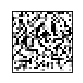

Iteration 2610000: loss=7.839897619987823e-10 prediction=4
Iteration 2620000: loss=7.83096254508564e-10 prediction=4
Iteration 2630000: loss=7.821245873174121e-10 prediction=4
Iteration 2640000: loss=7.811387092715449e-10 prediction=4
Iteration 2650000: loss=7.801617130098748e-10 prediction=4
Iteration 2660000: loss=7.791829403913653e-10 prediction=4
Iteration 2670000: loss=7.781810751339435e-10 prediction=4
Iteration 2680000: loss=7.771703280923248e-10 prediction=4
Iteration 2690000: loss=7.76159581050706e-10 prediction=4
Iteration 2700000: loss=7.751541630796055e-10 prediction=4


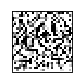

Iteration 2710000: loss=7.741451923948262e-10 prediction=4
Iteration 2720000: loss=7.731735252036742e-10 prediction=4
Iteration 2730000: loss=7.722764649997771e-10 prediction=4
Iteration 2740000: loss=7.713829575095588e-10 prediction=4
Iteration 2750000: loss=7.70496555446698e-10 prediction=4
Iteration 2760000: loss=7.696225878817131e-10 prediction=4
Iteration 2770000: loss=7.68769936598801e-10 prediction=4
Iteration 2780000: loss=7.679243907432465e-10 prediction=4
Iteration 2790000: loss=7.670664103898162e-10 prediction=4
Iteration 2800000: loss=7.662332990321374e-10 prediction=4


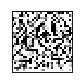

Iteration 2810000: loss=7.653717659650283e-10 prediction=4
Iteration 2820000: loss=7.645031274705616e-10 prediction=4
Iteration 2830000: loss=7.636220544782191e-10 prediction=4
Iteration 2840000: loss=7.627729559089858e-10 prediction=4
Iteration 2850000: loss=7.618474739956582e-10 prediction=4
Iteration 2860000: loss=7.611138386209859e-10 prediction=4
Iteration 2870000: loss=7.60417506739941e-10 prediction=4
Iteration 2880000: loss=7.597336093567719e-10 prediction=4
Iteration 2890000: loss=7.59055041044121e-10 prediction=4
Iteration 2900000: loss=7.583818018019883e-10 prediction=4


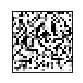

Iteration 2910000: loss=7.577121152735344e-10 prediction=4
Iteration 2920000: loss=7.570672977408321e-10 prediction=4
Iteration 2930000: loss=7.564437964902027e-10 prediction=4
Iteration 2940000: loss=7.558220715964126e-10 prediction=4
Iteration 2950000: loss=7.552021230594619e-10 prediction=4
Iteration 2960000: loss=7.54594609020387e-10 prediction=4
Iteration 2970000: loss=7.540332802591365e-10 prediction=4
Iteration 2980000: loss=7.53507478634674e-10 prediction=4
Iteration 2990000: loss=7.529994405786056e-10 prediction=4
Iteration 3000000: loss=7.525269296593251e-10 prediction=4


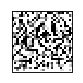

Iteration 3010000: loss=7.521663292209269e-10 prediction=4
Iteration 3020000: loss=7.518448086329954e-10 prediction=4
Iteration 3030000: loss=7.51452233771488e-10 prediction=4
Iteration 3040000: loss=7.510916333330897e-10 prediction=4
Iteration 3050000: loss=7.508216270935009e-10 prediction=4
Iteration 3060000: loss=7.506351096253638e-10 prediction=4
Iteration 3070000: loss=7.50471684796139e-10 prediction=4
Iteration 3080000: loss=7.503437871037022e-10 prediction=4
Iteration 3090000: loss=7.502372056933382e-10 prediction=4
Iteration 3100000: loss=7.501359533534924e-10 prediction=4


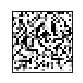

Iteration 3110000: loss=7.50080886291471e-10 prediction=4
Iteration 3120000: loss=7.501093080009014e-10 prediction=4
Iteration 3130000: loss=7.501750332039592e-10 prediction=4
Iteration 3140000: loss=7.50249640191214e-10 prediction=4
Iteration 3150000: loss=7.50338458033184e-10 prediction=4
Iteration 3160000: loss=7.504308285888328e-10 prediction=4
Iteration 3170000: loss=7.50507211932927e-10 prediction=4
Iteration 3180000: loss=7.505178700739634e-10 prediction=4
Iteration 3190000: loss=7.503793142404902e-10 prediction=4
Iteration 3200000: loss=7.502354293364988e-10 prediction=4


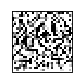

Iteration 3210000: loss=7.501359533534924e-10 prediction=4
Iteration 3220000: loss=7.5005424093888e-10 prediction=4
Iteration 3230000: loss=7.499387777443189e-10 prediction=4
Iteration 3240000: loss=7.497931164834881e-10 prediction=4
Iteration 3250000: loss=7.496083753721905e-10 prediction=4
Iteration 3260000: loss=7.494200815472141e-10 prediction=4
Iteration 3270000: loss=7.491518516644646e-10 prediction=4
Iteration 3280000: loss=7.488711872838394e-10 prediction=4
Iteration 3290000: loss=7.485692066211413e-10 prediction=4
Iteration 3300000: loss=7.482832131699979e-10 prediction=4


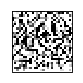

Iteration 3310000: loss=7.479759034367817e-10 prediction=4
Iteration 3320000: loss=7.476170793552228e-10 prediction=4
Iteration 3330000: loss=7.472724661283792e-10 prediction=4
Iteration 3340000: loss=7.469331819720537e-10 prediction=4
Iteration 3350000: loss=7.465903451020495e-10 prediction=4
Iteration 3360000: loss=7.46242179161527e-10 prediction=4
Iteration 3370000: loss=7.458993422915228e-10 prediction=4
Iteration 3380000: loss=7.455600581351973e-10 prediction=4
Iteration 3390000: loss=7.451372852074201e-10 prediction=4
Iteration 3400000: loss=7.447038541386064e-10 prediction=4


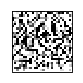

Iteration 3410000: loss=7.443112792770989e-10 prediction=4
Iteration 3420000: loss=7.439382443408249e-10 prediction=4
Iteration 3430000: loss=7.435367876951204e-10 prediction=4
Iteration 3440000: loss=7.431157911241826e-10 prediction=4
Iteration 3450000: loss=7.426752546280113e-10 prediction=4
Iteration 3460000: loss=7.422222836339643e-10 prediction=4
Iteration 3470000: loss=7.41755101785202e-10 prediction=4
Iteration 3480000: loss=7.412932490069579e-10 prediction=4
Iteration 3490000: loss=7.408491597971079e-10 prediction=4
Iteration 3500000: loss=7.404139523714548e-10 prediction=4


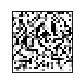

Iteration 3510000: loss=7.399609813774077e-10 prediction=4
Iteration 3520000: loss=7.394831413876091e-10 prediction=4
Iteration 3530000: loss=7.38994643256774e-10 prediction=4
Iteration 3540000: loss=7.384208799976477e-10 prediction=4
Iteration 3550000: loss=7.37845340381682e-10 prediction=4
Iteration 3560000: loss=7.372751298362346e-10 prediction=4
Iteration 3570000: loss=7.366995902202689e-10 prediction=4
Iteration 3580000: loss=7.361027343222304e-10 prediction=4
Iteration 3590000: loss=7.355129838515495e-10 prediction=4
Iteration 3600000: loss=7.349143515966716e-10 prediction=4


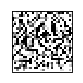

Iteration 3610000: loss=7.342979557733997e-10 prediction=4
Iteration 3620000: loss=7.336762308796096e-10 prediction=4
Iteration 3630000: loss=7.330775986247318e-10 prediction=4
Iteration 3640000: loss=7.324967299382479e-10 prediction=4
Iteration 3650000: loss=7.319034267538882e-10 prediction=4
Iteration 3660000: loss=7.312941363579739e-10 prediction=4
Iteration 3670000: loss=7.30677740534702e-10 prediction=4
Iteration 3680000: loss=7.300666737819483e-10 prediction=4
Iteration 3690000: loss=7.294502779586765e-10 prediction=4
Iteration 3700000: loss=7.288232239943682e-10 prediction=4


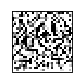

Iteration 3710000: loss=7.281979463868993e-10 prediction=4
Iteration 3720000: loss=7.27553128854197e-10 prediction=4
Iteration 3730000: loss=7.268905477531007e-10 prediction=4
Iteration 3740000: loss=7.262208612246468e-10 prediction=4
Iteration 3750000: loss=7.255760436919445e-10 prediction=4
Iteration 3760000: loss=7.248690536698632e-10 prediction=4
Iteration 3770000: loss=7.241691690751395e-10 prediction=4
Iteration 3780000: loss=7.233786902816064e-10 prediction=4
Iteration 3790000: loss=7.225793297038763e-10 prediction=4
Iteration 3800000: loss=7.217995090513796e-10 prediction=4


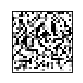

Iteration 3810000: loss=7.209877139757737e-10 prediction=4
Iteration 3820000: loss=7.201101936971099e-10 prediction=4
Iteration 3830000: loss=7.192468842731614e-10 prediction=4
Iteration 3840000: loss=7.184421946249131e-10 prediction=4
Iteration 3850000: loss=7.176499394745406e-10 prediction=4
Iteration 3860000: loss=7.168470261831317e-10 prediction=4
Iteration 3870000: loss=7.160121384686136e-10 prediction=4
Iteration 3880000: loss=7.151434999741468e-10 prediction=4
Iteration 3890000: loss=7.143174940438257e-10 prediction=4
Iteration 3900000: loss=7.135589896734018e-10 prediction=4


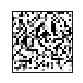

Iteration 3910000: loss=7.127862744482627e-10 prediction=4
Iteration 3920000: loss=7.119957956547296e-10 prediction=4
Iteration 3930000: loss=7.112088695748753e-10 prediction=4
Iteration 3940000: loss=7.10404179926627e-10 prediction=4
Iteration 3950000: loss=7.095781739963058e-10 prediction=4
Iteration 3960000: loss=7.088125641985243e-10 prediction=4
Iteration 3970000: loss=7.080593888986186e-10 prediction=4
Iteration 3980000: loss=7.072813446029613e-10 prediction=4
Iteration 3990000: loss=7.065192875188586e-10 prediction=4
Iteration 4000000: loss=7.057483486505589e-10 prediction=4


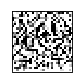

Iteration 4010000: loss=7.049667516412228e-10 prediction=4
Iteration 4020000: loss=7.041798255613685e-10 prediction=4
Iteration 4030000: loss=7.032880944279896e-10 prediction=4
Iteration 4040000: loss=7.023643888715014e-10 prediction=4
Iteration 4050000: loss=7.014104852487435e-10 prediction=4
Iteration 4060000: loss=7.004281599165552e-10 prediction=4
Iteration 4070000: loss=6.994493872980456e-10 prediction=4
Iteration 4080000: loss=6.985061418163241e-10 prediction=4
Iteration 4090000: loss=6.975628963346026e-10 prediction=4
Iteration 4100000: loss=6.966160981392022e-10 prediction=4


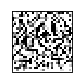

Iteration 4110000: loss=6.956604181596049e-10 prediction=4
Iteration 4120000: loss=6.946194730517163e-10 prediction=4
Iteration 4130000: loss=6.935998442259006e-10 prediction=4
Iteration 4140000: loss=6.925855444706031e-10 prediction=4
Iteration 4150000: loss=6.915783501426631e-10 prediction=4
Iteration 4160000: loss=6.905516158894898e-10 prediction=4
Iteration 4170000: loss=6.895266579931558e-10 prediction=4
Iteration 4180000: loss=6.884999237399825e-10 prediction=4
Iteration 4190000: loss=6.874660840594515e-10 prediction=4
Iteration 4200000: loss=6.864571133746722e-10 prediction=4


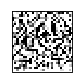

Iteration 4210000: loss=6.854552481172504e-10 prediction=4
Iteration 4220000: loss=6.844551592166681e-10 prediction=4
Iteration 4230000: loss=6.834568466729252e-10 prediction=4
Iteration 4240000: loss=6.8243544149027e-10 prediction=4
Iteration 4250000: loss=6.814140363076149e-10 prediction=4
Iteration 4260000: loss=6.803926311249597e-10 prediction=4
Iteration 4270000: loss=6.793712259423046e-10 prediction=4
Iteration 4280000: loss=6.783356099049342e-10 prediction=4
Iteration 4290000: loss=6.773106520086003e-10 prediction=4
Iteration 4300000: loss=6.763425375311272e-10 prediction=4


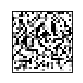

Iteration 4310000: loss=6.753726466968146e-10 prediction=4
Iteration 4320000: loss=6.744205194308961e-10 prediction=4
Iteration 4330000: loss=6.734808266628534e-10 prediction=4
Iteration 4340000: loss=6.725553447495258e-10 prediction=4
Iteration 4350000: loss=6.716494027614317e-10 prediction=4
Iteration 4360000: loss=6.707523425575346e-10 prediction=4
Iteration 4370000: loss=6.698606114241556e-10 prediction=4
Iteration 4380000: loss=6.689635512202585e-10 prediction=4
Iteration 4390000: loss=6.680682673732008e-10 prediction=4
Iteration 4400000: loss=6.671960761650553e-10 prediction=4


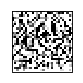

Iteration 4410000: loss=6.663576357368584e-10 prediction=4
Iteration 4420000: loss=6.655209716655008e-10 prediction=4
Iteration 4430000: loss=6.647038475193767e-10 prediction=4
Iteration 4440000: loss=6.63888499730092e-10 prediction=4
Iteration 4450000: loss=6.631442062143833e-10 prediction=4
Iteration 4460000: loss=6.624141235533898e-10 prediction=4
Iteration 4470000: loss=6.616858172492357e-10 prediction=4
Iteration 4480000: loss=6.609557345882422e-10 prediction=4
Iteration 4490000: loss=6.602220992135699e-10 prediction=4
Iteration 4500000: loss=6.594351731337156e-10 prediction=4


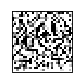

Iteration 4510000: loss=6.586446943401825e-10 prediction=4
Iteration 4520000: loss=6.57861320974007e-10 prediction=4
Iteration 4530000: loss=6.570779476078314e-10 prediction=4
Iteration 4540000: loss=6.562963505984953e-10 prediction=4
Iteration 4550000: loss=6.55527188087035e-10 prediction=4
Iteration 4560000: loss=6.547669073597717e-10 prediction=4
Iteration 4570000: loss=6.540084029893478e-10 prediction=4
Iteration 4580000: loss=6.532463459052451e-10 prediction=4
Iteration 4590000: loss=6.525375795263244e-10 prediction=4
Iteration 4600000: loss=6.519620399103587e-10 prediction=4


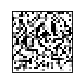

Iteration 4610000: loss=6.514166983606628e-10 prediction=4
Iteration 4620000: loss=6.508731331678064e-10 prediction=4
Iteration 4630000: loss=6.503348970454681e-10 prediction=4
Iteration 4640000: loss=6.497913318526116e-10 prediction=4
Iteration 4650000: loss=6.492619775144703e-10 prediction=4
Iteration 4660000: loss=6.487255177489715e-10 prediction=4
Iteration 4670000: loss=6.481855052697938e-10 prediction=4
Iteration 4680000: loss=6.476561509316525e-10 prediction=4
Iteration 4690000: loss=6.471285729503506e-10 prediction=4
Iteration 4700000: loss=6.466436275331944e-10 prediction=4


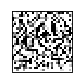

Iteration 4710000: loss=6.461533530455199e-10 prediction=4
Iteration 4720000: loss=6.456559731304878e-10 prediction=4
Iteration 4730000: loss=6.451603695722952e-10 prediction=4
Iteration 4740000: loss=6.446736477982995e-10 prediction=4
Iteration 4750000: loss=6.442029132358584e-10 prediction=4
Iteration 4760000: loss=6.437357313870962e-10 prediction=4
Iteration 4770000: loss=6.432614441109763e-10 prediction=4
Iteration 4780000: loss=6.427871568348564e-10 prediction=4
Iteration 4790000: loss=6.42323527699773e-10 prediction=4
Iteration 4800000: loss=6.418527931373319e-10 prediction=4


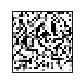

Iteration 4810000: loss=6.413856112885696e-10 prediction=4
Iteration 4820000: loss=6.409184294398074e-10 prediction=4
Iteration 4830000: loss=6.404530239478845e-10 prediction=4
Iteration 4840000: loss=6.399965002401586e-10 prediction=4
Iteration 4850000: loss=6.395559637439874e-10 prediction=4
Iteration 4860000: loss=6.391225326751737e-10 prediction=4
Iteration 4870000: loss=6.386855488926813e-10 prediction=4
Iteration 4880000: loss=6.38262775964904e-10 prediction=4
Iteration 4890000: loss=6.378950700991481e-10 prediction=4
Iteration 4900000: loss=6.375326933039105e-10 prediction=4


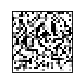

Iteration 4910000: loss=6.370051153226086e-10 prediction=4
Iteration 4920000: loss=6.364633264865915e-10 prediction=4
Iteration 4930000: loss=6.359108795095381e-10 prediction=4
Iteration 4940000: loss=6.353584325324846e-10 prediction=4
Iteration 4950000: loss=6.347864456301977e-10 prediction=4
Iteration 4960000: loss=6.342251168689472e-10 prediction=4
Iteration 4970000: loss=6.336691171782149e-10 prediction=4
Iteration 4980000: loss=6.331148938443221e-10 prediction=4
Iteration 4990000: loss=6.325624468672686e-10 prediction=4
Iteration 5000000: loss=6.320117762470545e-10 prediction=4


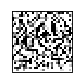

Iteration 5010000: loss=6.314806455520738e-10 prediction=4
Iteration 5020000: loss=6.309743838528448e-10 prediction=4
Iteration 5030000: loss=6.304645694399369e-10 prediction=4
Iteration 5040000: loss=6.299707422385836e-10 prediction=4
Iteration 5050000: loss=6.294733623235516e-10 prediction=4
Iteration 5060000: loss=6.289830878358771e-10 prediction=4
Iteration 5070000: loss=6.285070242029178e-10 prediction=4
Iteration 5080000: loss=6.280256314994404e-10 prediction=4
Iteration 5090000: loss=6.275495678664811e-10 prediction=4
Iteration 5100000: loss=6.270592933788066e-10 prediction=4


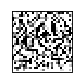

Iteration 5110000: loss=6.265565843932563e-10 prediction=4
Iteration 5120000: loss=6.260574281213849e-10 prediction=4
Iteration 5130000: loss=6.25556495492674e-10 prediction=4
Iteration 5140000: loss=6.250697737186783e-10 prediction=4
Iteration 5150000: loss=6.245848283015221e-10 prediction=4
Iteration 5160000: loss=6.241034355980446e-10 prediction=4
Iteration 5170000: loss=6.236238192514065e-10 prediction=4
Iteration 5180000: loss=6.231424265479291e-10 prediction=4
Iteration 5190000: loss=6.226610338444516e-10 prediction=4
Iteration 5200000: loss=6.221814174978135e-10 prediction=4


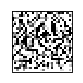

Iteration 5210000: loss=6.216946957238179e-10 prediction=4
Iteration 5220000: loss=6.212150793771798e-10 prediction=4
Iteration 5230000: loss=6.207638847399721e-10 prediction=4
Iteration 5240000: loss=6.203038083185675e-10 prediction=4
Iteration 5250000: loss=6.198455082540022e-10 prediction=4
Iteration 5260000: loss=6.193872081894369e-10 prediction=4
Iteration 5270000: loss=6.189235790543535e-10 prediction=4
Iteration 5280000: loss=6.184563972055912e-10 prediction=4
Iteration 5290000: loss=6.180247424936169e-10 prediction=4
Iteration 5300000: loss=6.176090749931973e-10 prediction=4


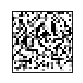

Iteration 5310000: loss=6.172058419906534e-10 prediction=4
Iteration 5320000: loss=6.167990562744308e-10 prediction=4
Iteration 5330000: loss=6.164047050560839e-10 prediction=4
Iteration 5340000: loss=6.160174592650947e-10 prediction=4
Iteration 5350000: loss=6.156213316899084e-10 prediction=4
Iteration 5360000: loss=6.152323095420797e-10 prediction=4
Iteration 5370000: loss=6.148361819668935e-10 prediction=4
Iteration 5380000: loss=6.144471598190648e-10 prediction=4
Iteration 5390000: loss=6.140634667417544e-10 prediction=4
Iteration 5400000: loss=6.136726682370863e-10 prediction=4


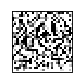

Iteration 5410000: loss=6.132907515166153e-10 prediction=4
Iteration 5420000: loss=6.1292126929402e-10 prediction=4
Iteration 5430000: loss=6.125464580009066e-10 prediction=4
Iteration 5440000: loss=6.121823048488295e-10 prediction=4
Iteration 5450000: loss=6.118341389083071e-10 prediction=4
Iteration 5460000: loss=6.114806438972664e-10 prediction=4
Iteration 5470000: loss=6.111307015999046e-10 prediction=4
Iteration 5480000: loss=6.107967465140973e-10 prediction=4
Iteration 5490000: loss=6.104663441419689e-10 prediction=4
Iteration 5500000: loss=6.101306126993222e-10 prediction=4


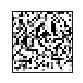

Iteration 5510000: loss=6.097913285429968e-10 prediction=4
Iteration 5520000: loss=6.094538207435107e-10 prediction=4
Iteration 5530000: loss=6.091092075166671e-10 prediction=4
Iteration 5540000: loss=6.087521597919476e-10 prediction=4
Iteration 5550000: loss=6.083933357103888e-10 prediction=4
Iteration 5560000: loss=6.080416170561875e-10 prediction=4
Iteration 5570000: loss=6.076881220451469e-10 prediction=4
Iteration 5580000: loss=6.07338179747785e-10 prediction=4
Iteration 5590000: loss=6.069864610935838e-10 prediction=4
Iteration 5600000: loss=6.066436242235795e-10 prediction=4


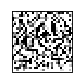

Iteration 5610000: loss=6.063096691377723e-10 prediction=4
Iteration 5620000: loss=6.059828194793226e-10 prediction=4
Iteration 5630000: loss=6.056577461777124e-10 prediction=4
Iteration 5640000: loss=6.053308965192628e-10 prediction=4
Iteration 5650000: loss=6.050040468608131e-10 prediction=4
Iteration 5660000: loss=6.046985134844363e-10 prediction=4
Iteration 5670000: loss=6.043929801080594e-10 prediction=4
Iteration 5680000: loss=6.041087630137554e-10 prediction=4
Iteration 5690000: loss=6.038121114215755e-10 prediction=4
Iteration 5700000: loss=6.035207888999139e-10 prediction=4


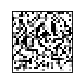

Iteration 5710000: loss=6.032276900214129e-10 prediction=4
Iteration 5720000: loss=6.029257093587148e-10 prediction=4
Iteration 5730000: loss=6.026361631938926e-10 prediction=4
Iteration 5740000: loss=6.023519460995885e-10 prediction=4
Iteration 5750000: loss=6.020712817189633e-10 prediction=4
Iteration 5760000: loss=6.017906173383381e-10 prediction=4
Iteration 5770000: loss=6.015028475303552e-10 prediction=4
Iteration 5780000: loss=6.012168540792118e-10 prediction=4
Iteration 5790000: loss=6.009166497733531e-10 prediction=4
Iteration 5800000: loss=6.006182218243339e-10 prediction=4


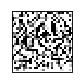

Iteration 5810000: loss=6.003251229458328e-10 prediction=4
Iteration 5820000: loss=6.000266949968136e-10 prediction=4
Iteration 5830000: loss=5.99735372475152e-10 prediction=4
Iteration 5840000: loss=5.994458263103297e-10 prediction=4
Iteration 5850000: loss=5.991598328591863e-10 prediction=4
Iteration 5860000: loss=5.988773921217216e-10 prediction=4
Iteration 5870000: loss=5.985967277410964e-10 prediction=4
Iteration 5880000: loss=5.983125106467924e-10 prediction=4
Iteration 5890000: loss=5.980176354114519e-10 prediction=4
Iteration 5900000: loss=5.977334183171479e-10 prediction=4


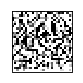

Iteration 5910000: loss=5.97445648509165e-10 prediction=4
Iteration 5920000: loss=5.97161431414861e-10 prediction=4
Iteration 5930000: loss=5.968843197479146e-10 prediction=4
Iteration 5940000: loss=5.966089844378075e-10 prediction=4
Iteration 5950000: loss=5.963407545550581e-10 prediction=4
Iteration 5960000: loss=5.960707483154692e-10 prediction=4
Iteration 5970000: loss=5.958114002169168e-10 prediction=4
Iteration 5980000: loss=5.955520521183644e-10 prediction=4
Iteration 5990000: loss=5.952944803766513e-10 prediction=4
Iteration 6000000: loss=5.950084869255079e-10 prediction=4


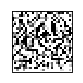

Iteration 6010000: loss=5.947224934743645e-10 prediction=4
Iteration 6020000: loss=5.94427618239024e-10 prediction=4
Iteration 6030000: loss=5.941327430036836e-10 prediction=4
Iteration 6040000: loss=5.938431968388613e-10 prediction=4
Iteration 6050000: loss=5.935607561013967e-10 prediction=4
Iteration 6060000: loss=5.932960789323261e-10 prediction=4
Iteration 6070000: loss=5.930314017632554e-10 prediction=4
Iteration 6080000: loss=5.92772053664703e-10 prediction=4
Iteration 6090000: loss=5.925162582798293e-10 prediction=4
Iteration 6100000: loss=5.922569101812769e-10 prediction=4


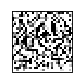

Iteration 6110000: loss=5.919957857258851e-10 prediction=4
Iteration 6120000: loss=5.917275558431356e-10 prediction=4
Iteration 6130000: loss=5.914522205330286e-10 prediction=4
Iteration 6140000: loss=5.91178661579761e-10 prediction=4
Iteration 6150000: loss=5.909139844106903e-10 prediction=4
Iteration 6160000: loss=5.906475308847803e-10 prediction=4
Iteration 6170000: loss=5.903775246451914e-10 prediction=4
Iteration 6180000: loss=5.90109294762442e-10 prediction=4
Iteration 6190000: loss=5.898286303818168e-10 prediction=4
Iteration 6200000: loss=5.895568477853885e-10 prediction=4


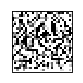

Iteration 6210000: loss=5.892779597616027e-10 prediction=4
Iteration 6220000: loss=5.889937426672986e-10 prediction=4
Iteration 6230000: loss=5.887148546435128e-10 prediction=4
Iteration 6240000: loss=5.884324139060482e-10 prediction=4
Iteration 6250000: loss=5.881517495254229e-10 prediction=4
Iteration 6260000: loss=5.878764142153159e-10 prediction=4
Iteration 6270000: loss=5.876117370462453e-10 prediction=4
Iteration 6280000: loss=5.873790343002838e-10 prediction=4
Iteration 6290000: loss=5.871552133385194e-10 prediction=4
Iteration 6300000: loss=5.869278396630762e-10 prediction=4


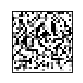

Iteration 6310000: loss=5.867004659876329e-10 prediction=4
Iteration 6320000: loss=5.864819740963867e-10 prediction=4
Iteration 6330000: loss=5.862599294914617e-10 prediction=4
Iteration 6340000: loss=5.860094631771062e-10 prediction=4
Iteration 6350000: loss=5.857749840743054e-10 prediction=4
Iteration 6360000: loss=5.855405049715046e-10 prediction=4
Iteration 6370000: loss=5.853149076529007e-10 prediction=4
Iteration 6380000: loss=5.850822049069393e-10 prediction=4
Iteration 6390000: loss=5.848583839451749e-10 prediction=4
Iteration 6400000: loss=5.846345629834104e-10 prediction=4


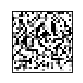

Iteration 6410000: loss=5.844089656648066e-10 prediction=4
Iteration 6420000: loss=5.84170933848327e-10 prediction=4
Iteration 6430000: loss=5.839098093929351e-10 prediction=4
Iteration 6440000: loss=5.836451322238645e-10 prediction=4
Iteration 6450000: loss=5.833822314116333e-10 prediction=4
Iteration 6460000: loss=5.83128212383599e-10 prediction=4
Iteration 6470000: loss=5.828759697124042e-10 prediction=4
Iteration 6480000: loss=5.826237270412093e-10 prediction=4
Iteration 6490000: loss=5.823679316563357e-10 prediction=4
Iteration 6500000: loss=5.821210180556591e-10 prediction=4


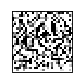

Iteration 6510000: loss=5.81872328098143e-10 prediction=4
Iteration 6520000: loss=5.816218617837876e-10 prediction=4
Iteration 6530000: loss=5.813767245399504e-10 prediction=4
Iteration 6540000: loss=5.811280345824343e-10 prediction=4
Iteration 6550000: loss=5.808846736954365e-10 prediction=4
Iteration 6560000: loss=5.806342073810811e-10 prediction=4
Iteration 6570000: loss=5.80385517423565e-10 prediction=4
Iteration 6580000: loss=5.801510383207642e-10 prediction=4
Iteration 6590000: loss=5.799130065042846e-10 prediction=4
Iteration 6600000: loss=5.796909618993595e-10 prediction=4


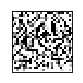

Iteration 6610000: loss=5.794635882239163e-10 prediction=4
Iteration 6620000: loss=5.792468726895095e-10 prediction=4
Iteration 6630000: loss=5.79005288159351e-10 prediction=4
Iteration 6640000: loss=5.787512691313168e-10 prediction=4
Iteration 6650000: loss=5.784883683190856e-10 prediction=4
Iteration 6660000: loss=5.782343492910513e-10 prediction=4
Iteration 6670000: loss=5.779803302630171e-10 prediction=4
Iteration 6680000: loss=5.777280875918223e-10 prediction=4
Iteration 6690000: loss=5.775113720574154e-10 prediction=4
Iteration 6700000: loss=5.772857747388116e-10 prediction=4


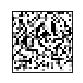

Iteration 6710000: loss=5.770530719928502e-10 prediction=4
Iteration 6720000: loss=5.768114874626917e-10 prediction=4
Iteration 6730000: loss=5.765556920778181e-10 prediction=4
Iteration 6740000: loss=5.762981203361051e-10 prediction=4
Iteration 6750000: loss=5.760369958807132e-10 prediction=4
Iteration 6760000: loss=5.757812004958396e-10 prediction=4
Iteration 6770000: loss=5.755182996836083e-10 prediction=4
Iteration 6780000: loss=5.752571752282165e-10 prediction=4
Iteration 6790000: loss=5.749960507728247e-10 prediction=4
Iteration 6800000: loss=5.747278208900752e-10 prediction=4


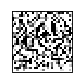

Iteration 6810000: loss=5.744684727915228e-10 prediction=4
Iteration 6820000: loss=5.742037956224522e-10 prediction=4
Iteration 6830000: loss=5.739408948102209e-10 prediction=4
Iteration 6840000: loss=5.736797703548291e-10 prediction=4
Iteration 6850000: loss=5.734168695425979e-10 prediction=4
Iteration 6860000: loss=5.731592978008848e-10 prediction=4
Iteration 6870000: loss=5.729123842002082e-10 prediction=4
Iteration 6880000: loss=5.726654705995315e-10 prediction=4
Iteration 6890000: loss=5.724203333556943e-10 prediction=4
Iteration 6900000: loss=5.721751961118571e-10 prediction=4


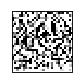

Iteration 6910000: loss=5.719158480133046e-10 prediction=4
Iteration 6920000: loss=5.716547235579128e-10 prediction=4
Iteration 6930000: loss=5.713971518161998e-10 prediction=4
Iteration 6940000: loss=5.711431327881655e-10 prediction=4
Iteration 6950000: loss=5.708873374032919e-10 prediction=4
Iteration 6960000: loss=5.706439765162941e-10 prediction=4
Iteration 6970000: loss=5.704023919861356e-10 prediction=4
Iteration 6980000: loss=5.701661365264954e-10 prediction=4
Iteration 6990000: loss=5.699281047100158e-10 prediction=4
Iteration 7000000: loss=5.696882965366967e-10 prediction=4


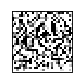

Iteration 7010000: loss=5.694538174338959e-10 prediction=4
Iteration 7020000: loss=5.692157856174163e-10 prediction=4
Iteration 7030000: loss=5.68979530157776e-10 prediction=4
Iteration 7040000: loss=5.687432746981358e-10 prediction=4
Iteration 7050000: loss=5.685070192384956e-10 prediction=4
Iteration 7060000: loss=5.682796455630523e-10 prediction=4
Iteration 7070000: loss=5.680433901034121e-10 prediction=4
Iteration 7080000: loss=5.677982528595749e-10 prediction=4
Iteration 7090000: loss=5.675424574747012e-10 prediction=4
Iteration 7100000: loss=5.672848857329882e-10 prediction=4


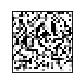

Iteration 7110000: loss=5.67030866704954e-10 prediction=4
Iteration 7120000: loss=5.667928348884743e-10 prediction=4
Iteration 7130000: loss=5.665530267151553e-10 prediction=4
Iteration 7140000: loss=5.663114421849968e-10 prediction=4
Iteration 7150000: loss=5.660485413727656e-10 prediction=4
Iteration 7160000: loss=5.65774982419498e-10 prediction=4
Iteration 7170000: loss=5.655049761799091e-10 prediction=4
Iteration 7180000: loss=5.652349699403203e-10 prediction=4
Iteration 7190000: loss=5.649631873438921e-10 prediction=4
Iteration 7200000: loss=5.646754175359092e-10 prediction=4


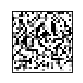

Iteration 7210000: loss=5.643894240847658e-10 prediction=4
Iteration 7220000: loss=5.640998779199435e-10 prediction=4
Iteration 7230000: loss=5.638174371824789e-10 prediction=4
Iteration 7240000: loss=5.635385491586931e-10 prediction=4
Iteration 7250000: loss=5.632649902054254e-10 prediction=4
Iteration 7260000: loss=5.629949839658366e-10 prediction=4
Iteration 7270000: loss=5.627267540830871e-10 prediction=4
Iteration 7280000: loss=5.624549714866589e-10 prediction=4
Iteration 7290000: loss=5.621885179607489e-10 prediction=4
Iteration 7300000: loss=5.619256171485176e-10 prediction=4


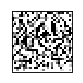

Iteration 7310000: loss=5.616591636226076e-10 prediction=4
Iteration 7320000: loss=5.613909337398582e-10 prediction=4
Iteration 7330000: loss=5.611227038571087e-10 prediction=4
Iteration 7340000: loss=5.608669084722351e-10 prediction=4
Iteration 7350000: loss=5.606128894442008e-10 prediction=4
Iteration 7360000: loss=5.603641994866848e-10 prediction=4
Iteration 7370000: loss=5.601190622428476e-10 prediction=4
Iteration 7380000: loss=5.598739249990103e-10 prediction=4
Iteration 7390000: loss=5.596376695393701e-10 prediction=4
Iteration 7400000: loss=5.593996377228905e-10 prediction=4


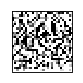

Iteration 7410000: loss=5.591722640474472e-10 prediction=4
Iteration 7420000: loss=5.589466667288434e-10 prediction=4
Iteration 7430000: loss=5.58722845767079e-10 prediction=4
Iteration 7440000: loss=5.585008011621539e-10 prediction=4
Iteration 7450000: loss=5.582805329140683e-10 prediction=4
Iteration 7460000: loss=5.580602646659827e-10 prediction=4
Iteration 7470000: loss=5.578453254884153e-10 prediction=4
Iteration 7480000: loss=5.576321626676872e-10 prediction=4
Iteration 7490000: loss=5.574243289174774e-10 prediction=4
Iteration 7500000: loss=5.572076133830706e-10 prediction=4


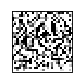

Iteration 7510000: loss=5.569962269191819e-10 prediction=4
Iteration 7520000: loss=5.567866168121327e-10 prediction=4
Iteration 7530000: loss=5.565841121324411e-10 prediction=4
Iteration 7540000: loss=5.563833838095888e-10 prediction=4
Iteration 7550000: loss=5.561968663414518e-10 prediction=4
Iteration 7560000: loss=5.560298887985482e-10 prediction=4
Iteration 7570000: loss=5.558522531146082e-10 prediction=4
Iteration 7580000: loss=5.556621829327923e-10 prediction=4
Iteration 7590000: loss=5.554614546099401e-10 prediction=4
Iteration 7600000: loss=5.552678317144455e-10 prediction=4


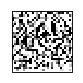

Iteration 7610000: loss=5.550866433168267e-10 prediction=4
Iteration 7620000: loss=5.549054549192078e-10 prediction=4
Iteration 7630000: loss=5.547207138079102e-10 prediction=4
Iteration 7640000: loss=5.545341963397732e-10 prediction=4
Iteration 7650000: loss=5.54342349801118e-10 prediction=4
Iteration 7660000: loss=5.541256342667111e-10 prediction=4
Iteration 7670000: loss=5.539089187323043e-10 prediction=4
Iteration 7680000: loss=5.536975322684157e-10 prediction=4
Iteration 7690000: loss=5.534825930908482e-10 prediction=4
Iteration 7700000: loss=5.532783120543172e-10 prediction=4


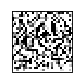

Iteration 7710000: loss=5.530704783041074e-10 prediction=4
Iteration 7720000: loss=5.528608681970582e-10 prediction=4
Iteration 7730000: loss=5.526601398742059e-10 prediction=4
Iteration 7740000: loss=5.524611879081931e-10 prediction=4
Iteration 7750000: loss=5.522586832285015e-10 prediction=4
Iteration 7760000: loss=5.520579549056492e-10 prediction=4
Iteration 7770000: loss=5.518590029396364e-10 prediction=4
Iteration 7780000: loss=5.516582746167842e-10 prediction=4
Iteration 7790000: loss=5.514628753644502e-10 prediction=4
Iteration 7800000: loss=5.512728051826343e-10 prediction=4


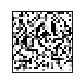

Iteration 7810000: loss=5.510809586439791e-10 prediction=4
Iteration 7820000: loss=5.508908884621633e-10 prediction=4
Iteration 7830000: loss=5.506972655666686e-10 prediction=4
Iteration 7840000: loss=5.505107480985316e-10 prediction=4
Iteration 7850000: loss=5.503224542735552e-10 prediction=4
Iteration 7860000: loss=5.501323840917394e-10 prediction=4
Iteration 7870000: loss=5.499423139099235e-10 prediction=4
Iteration 7880000: loss=5.497540200849471e-10 prediction=4
Iteration 7890000: loss=5.495532917620949e-10 prediction=4
Iteration 7900000: loss=5.493472343687245e-10 prediction=4


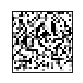

Iteration 7910000: loss=5.491553878300692e-10 prediction=4
Iteration 7920000: loss=5.489919630008444e-10 prediction=4
Iteration 7930000: loss=5.488285381716196e-10 prediction=4
Iteration 7940000: loss=5.486580079150372e-10 prediction=4
Iteration 7950000: loss=5.484999121563305e-10 prediction=4
Iteration 7960000: loss=5.483560272523391e-10 prediction=4
Iteration 7970000: loss=5.482299059167417e-10 prediction=4
Iteration 7980000: loss=5.481073372948231e-10 prediction=4
Iteration 7990000: loss=5.479794396023863e-10 prediction=4
Iteration 8000000: loss=5.478568709804676e-10 prediction=4


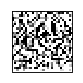

Iteration 8010000: loss=5.477094333627974e-10 prediction=4
Iteration 8020000: loss=5.475531139609302e-10 prediction=4
Iteration 8030000: loss=5.473932418453842e-10 prediction=4
Iteration 8040000: loss=5.472333697298382e-10 prediction=4
Iteration 8050000: loss=5.470734976142921e-10 prediction=4
Iteration 8060000: loss=5.469207309261037e-10 prediction=4
Iteration 8070000: loss=5.467786223789517e-10 prediction=4
Iteration 8080000: loss=5.466382901886391e-10 prediction=4
Iteration 8090000: loss=5.464944052846477e-10 prediction=4
Iteration 8100000: loss=5.463469676669774e-10 prediction=4


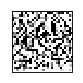

Iteration 8110000: loss=5.462048591198254e-10 prediction=4
Iteration 8120000: loss=5.46060974215834e-10 prediction=4
Iteration 8130000: loss=5.459153129550032e-10 prediction=4
Iteration 8140000: loss=5.457625462668148e-10 prediction=4
Iteration 8150000: loss=5.456133322923051e-10 prediction=4
Iteration 8160000: loss=5.454658946746349e-10 prediction=4
Iteration 8170000: loss=5.453220097706435e-10 prediction=4
Iteration 8180000: loss=5.451781248666521e-10 prediction=4
Iteration 8190000: loss=5.450377926763394e-10 prediction=4
Iteration 8200000: loss=5.449010131997056e-10 prediction=4


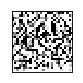

Iteration 8210000: loss=5.447553519388748e-10 prediction=4
Iteration 8220000: loss=5.446114670348834e-10 prediction=4
Iteration 8230000: loss=5.444658057740526e-10 prediction=4
Iteration 8240000: loss=5.443236972269005e-10 prediction=4
Iteration 8250000: loss=5.441815886797485e-10 prediction=4
Iteration 8260000: loss=5.440448092031147e-10 prediction=4
Iteration 8270000: loss=5.439009242991233e-10 prediction=4
Iteration 8280000: loss=5.437570393951319e-10 prediction=4
Iteration 8290000: loss=5.436149308479798e-10 prediction=4
Iteration 8300000: loss=5.434728223008278e-10 prediction=4


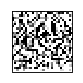

Iteration 8310000: loss=5.433342664673546e-10 prediction=4
Iteration 8320000: loss=5.432347904843482e-10 prediction=4
Iteration 8330000: loss=5.431530780697358e-10 prediction=4
Iteration 8340000: loss=5.430660365846052e-10 prediction=4
Iteration 8350000: loss=5.429754423857958e-10 prediction=4
Iteration 8360000: loss=5.428439919796801e-10 prediction=4
Iteration 8370000: loss=5.427143179304039e-10 prediction=4
Iteration 8380000: loss=5.425828675242883e-10 prediction=4
Iteration 8390000: loss=5.424496407613333e-10 prediction=4
Iteration 8400000: loss=5.423217430688965e-10 prediction=4


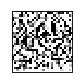

Iteration 8410000: loss=5.421920690196202e-10 prediction=4
Iteration 8420000: loss=5.420375259745924e-10 prediction=4
Iteration 8430000: loss=5.417906123739158e-10 prediction=4
Iteration 8440000: loss=5.415543569142756e-10 prediction=4
Iteration 8450000: loss=5.413394177367081e-10 prediction=4
Iteration 8460000: loss=5.411351367001771e-10 prediction=4
Iteration 8470000: loss=5.409344083773249e-10 prediction=4
Iteration 8480000: loss=5.407283509839544e-10 prediction=4
Iteration 8490000: loss=5.405205172337446e-10 prediction=4
Iteration 8500000: loss=5.403197889108924e-10 prediction=4


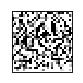

Iteration 8510000: loss=5.401208369448796e-10 prediction=4
Iteration 8520000: loss=5.399183322651879e-10 prediction=4
Iteration 8530000: loss=5.397140512286569e-10 prediction=4
Iteration 8540000: loss=5.395310864741987e-10 prediction=4
Iteration 8550000: loss=5.393498980765798e-10 prediction=4
Iteration 8560000: loss=5.391669333221216e-10 prediction=4
Iteration 8570000: loss=5.389857449245028e-10 prediction=4
Iteration 8580000: loss=5.38804556526884e-10 prediction=4
Iteration 8590000: loss=5.386215917724257e-10 prediction=4
Iteration 8600000: loss=5.384404033748069e-10 prediction=4


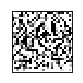

Iteration 8610000: loss=5.382592149771881e-10 prediction=4
Iteration 8620000: loss=5.380798029364087e-10 prediction=4
Iteration 8630000: loss=5.379021672524686e-10 prediction=4
Iteration 8640000: loss=5.377209788548498e-10 prediction=4
Iteration 8650000: loss=5.375344613867128e-10 prediction=4
Iteration 8660000: loss=5.373479439185758e-10 prediction=4
Iteration 8670000: loss=5.371667555209569e-10 prediction=4
Iteration 8680000: loss=5.369802380528199e-10 prediction=4
Iteration 8690000: loss=5.367919442278435e-10 prediction=4
Iteration 8700000: loss=5.365929922618307e-10 prediction=4


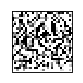

Iteration 8710000: loss=5.36363842229548e-10 prediction=4
Iteration 8720000: loss=5.361293631267472e-10 prediction=4
Iteration 8730000: loss=5.35901989451304e-10 prediction=4
Iteration 8740000: loss=5.356746157758607e-10 prediction=4
Iteration 8750000: loss=5.354419130298993e-10 prediction=4
Iteration 8760000: loss=5.352056575702591e-10 prediction=4
Iteration 8770000: loss=5.349765075379764e-10 prediction=4
Iteration 8780000: loss=5.347455811488544e-10 prediction=4
Iteration 8790000: loss=5.345182074734112e-10 prediction=4
Iteration 8800000: loss=5.342943865116467e-10 prediction=4


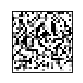

Iteration 8810000: loss=5.340705655498823e-10 prediction=4
Iteration 8820000: loss=5.338467445881179e-10 prediction=4
Iteration 8830000: loss=5.336246999831928e-10 prediction=4
Iteration 8840000: loss=5.334062080919466e-10 prediction=4
Iteration 8850000: loss=5.331877162007004e-10 prediction=4
Iteration 8860000: loss=5.329674479526147e-10 prediction=4
Iteration 8870000: loss=5.327507324182079e-10 prediction=4
Iteration 8880000: loss=5.325322405269617e-10 prediction=4
Iteration 8890000: loss=5.323155249925549e-10 prediction=4
Iteration 8900000: loss=5.320952567444692e-10 prediction=4


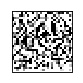

Iteration 8910000: loss=5.318749884963836e-10 prediction=4
Iteration 8920000: loss=5.316582729619768e-10 prediction=4
Iteration 8930000: loss=5.314397810707305e-10 prediction=4
Iteration 8940000: loss=5.312177364658055e-10 prediction=4
Iteration 8950000: loss=5.310099027155957e-10 prediction=4
Iteration 8960000: loss=5.30816279820101e-10 prediction=4
Iteration 8970000: loss=5.306262096382852e-10 prediction=4
Iteration 8980000: loss=5.3043436309963e-10 prediction=4
Iteration 8990000: loss=5.302496219883324e-10 prediction=4
Iteration 9000000: loss=5.300631045201953e-10 prediction=4


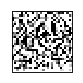

Iteration 9010000: loss=5.298765870520583e-10 prediction=4
Iteration 9020000: loss=5.297025040817971e-10 prediction=4
Iteration 9030000: loss=5.295284211115359e-10 prediction=4
Iteration 9040000: loss=5.29356114498114e-10 prediction=4
Iteration 9050000: loss=5.291820315278528e-10 prediction=4
Iteration 9060000: loss=5.29000843130234e-10 prediction=4
Iteration 9070000: loss=5.288107729484182e-10 prediction=4
Iteration 9080000: loss=5.286331372644781e-10 prediction=4
Iteration 9090000: loss=5.284501725100199e-10 prediction=4
Iteration 9100000: loss=5.282760895397587e-10 prediction=4


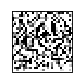

Iteration 9110000: loss=5.281037829263369e-10 prediction=4
Iteration 9120000: loss=5.279332526697544e-10 prediction=4
Iteration 9130000: loss=5.277556169858144e-10 prediction=4
Iteration 9140000: loss=5.275868630860714e-10 prediction=4
Iteration 9150000: loss=5.274127801158102e-10 prediction=4
Iteration 9160000: loss=5.272404735023883e-10 prediction=4
Iteration 9170000: loss=5.270663905321271e-10 prediction=4
Iteration 9180000: loss=5.268905312050265e-10 prediction=4
Iteration 9190000: loss=5.267146718779259e-10 prediction=4
Iteration 9200000: loss=5.265441416213434e-10 prediction=4


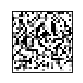

Iteration 9210000: loss=5.263700586510822e-10 prediction=4
Iteration 9220000: loss=5.26195975680821e-10 prediction=4
Iteration 9230000: loss=5.260218927105598e-10 prediction=4
Iteration 9240000: loss=5.258460333834591e-10 prediction=4
Iteration 9250000: loss=5.256666213426797e-10 prediction=4
Iteration 9260000: loss=5.254872093019003e-10 prediction=4
Iteration 9270000: loss=5.253095736179603e-10 prediction=4
Iteration 9280000: loss=5.251319379340202e-10 prediction=4
Iteration 9290000: loss=5.24957854963759e-10 prediction=4
Iteration 9300000: loss=5.247873247071766e-10 prediction=4


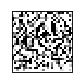

Iteration 9310000: loss=5.246043599527184e-10 prediction=4
Iteration 9320000: loss=5.244213951982601e-10 prediction=4
Iteration 9330000: loss=5.242437595143201e-10 prediction=4
Iteration 9340000: loss=5.240625711167013e-10 prediction=4
Iteration 9350000: loss=5.238813827190825e-10 prediction=4
Iteration 9360000: loss=5.237072997488212e-10 prediction=4
Iteration 9370000: loss=5.2353321677856e-10 prediction=4
Iteration 9380000: loss=5.233609101651382e-10 prediction=4
Iteration 9390000: loss=5.231903799085558e-10 prediction=4
Iteration 9400000: loss=5.230198496519733e-10 prediction=4


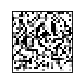

Iteration 9410000: loss=5.228368848975151e-10 prediction=4
Iteration 9420000: loss=5.226592492135751e-10 prediction=4
Iteration 9430000: loss=5.224816135296351e-10 prediction=4
Iteration 9440000: loss=5.222986487751768e-10 prediction=4
Iteration 9450000: loss=5.221192367343974e-10 prediction=4
Iteration 9460000: loss=5.219416010504574e-10 prediction=4
Iteration 9470000: loss=5.217302145865688e-10 prediction=4
Iteration 9480000: loss=5.215134990521619e-10 prediction=4
Iteration 9490000: loss=5.212807963062005e-10 prediction=4
Iteration 9500000: loss=5.210427644897209e-10 prediction=4


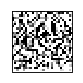

Iteration 9510000: loss=5.208100617437594e-10 prediction=4
Iteration 9520000: loss=5.205755826409586e-10 prediction=4
Iteration 9530000: loss=5.20337550824479e-10 prediction=4
Iteration 9540000: loss=5.201030717216781e-10 prediction=4
Iteration 9550000: loss=5.198650399051985e-10 prediction=4
Iteration 9560000: loss=5.196252317318795e-10 prediction=4
Iteration 9570000: loss=5.193889762722392e-10 prediction=4
Iteration 9580000: loss=5.191420626715626e-10 prediction=4
Iteration 9590000: loss=5.188880436435284e-10 prediction=4
Iteration 9600000: loss=5.186340246154941e-10 prediction=4


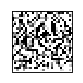

Iteration 9610000: loss=5.183906637284963e-10 prediction=4
Iteration 9620000: loss=5.181597373393743e-10 prediction=4
Iteration 9630000: loss=5.17932363663931e-10 prediction=4
Iteration 9640000: loss=5.177049899884878e-10 prediction=4
Iteration 9650000: loss=5.174936035245992e-10 prediction=4
Iteration 9660000: loss=5.172804407038711e-10 prediction=4
Iteration 9670000: loss=5.170708305968219e-10 prediction=4
Iteration 9680000: loss=5.168665495602909e-10 prediction=4
Iteration 9690000: loss=5.166747030216357e-10 prediction=4
Iteration 9700000: loss=5.164846328398198e-10 prediction=4


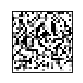

Iteration 9710000: loss=5.162963390148434e-10 prediction=4
Iteration 9720000: loss=5.161062688330276e-10 prediction=4
Iteration 9730000: loss=5.159161986512117e-10 prediction=4
Iteration 9740000: loss=5.157279048262353e-10 prediction=4
Iteration 9750000: loss=5.155378346444195e-10 prediction=4
Iteration 9760000: loss=5.153566462468007e-10 prediction=4
Iteration 9770000: loss=5.15163023351306e-10 prediction=4
Iteration 9780000: loss=5.149729531694902e-10 prediction=4
Iteration 9790000: loss=5.147846593445138e-10 prediction=4
Iteration 9800000: loss=5.145981418763768e-10 prediction=4


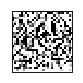

Iteration 9810000: loss=5.144062953377215e-10 prediction=4
Iteration 9820000: loss=5.142162251559057e-10 prediction=4
Iteration 9830000: loss=5.140279313309293e-10 prediction=4
Iteration 9840000: loss=5.138396375059529e-10 prediction=4
Iteration 9850000: loss=5.136513436809764e-10 prediction=4
Iteration 9860000: loss=5.13463049856e-10 prediction=4
Iteration 9870000: loss=5.132712033173448e-10 prediction=4
Iteration 9880000: loss=5.130775804218501e-10 prediction=4
Iteration 9890000: loss=5.128786284558373e-10 prediction=4
Iteration 9900000: loss=5.126850055603427e-10 prediction=4


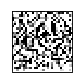

Iteration 9910000: loss=5.124931590216875e-10 prediction=4
Iteration 9920000: loss=5.122995361261928e-10 prediction=4
Iteration 9930000: loss=5.121059132306982e-10 prediction=4
Iteration 9940000: loss=5.119122903352036e-10 prediction=4
Iteration 9950000: loss=5.117257728670666e-10 prediction=4
Iteration 9960000: loss=5.115285972578931e-10 prediction=4
Iteration 9970000: loss=5.113403034329167e-10 prediction=4
Iteration 9980000: loss=5.111537859647797e-10 prediction=4
Iteration 9990000: loss=5.109708212103214e-10 prediction=4
Iteration 10000000: loss=5.108109490947754e-10 prediction=4


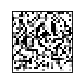

In [14]:
new_image_randn, loss_stats = generate_image(img, 4)

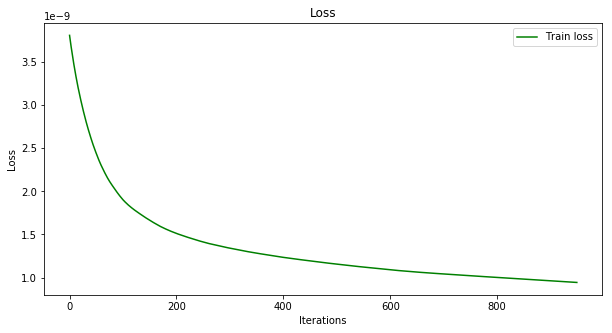

In [40]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.set_title("Loss")
plt.plot(loss_stats[50:], color='green', label='Train loss')

ax.set_ylabel("Loss")
ax.set_xlabel("Iterations")
ax.legend()
